In [1]:
#...... general imports

import numpy as np
import pickle
from helpers.SimulationAnalysis import SimulationAnalysis, readHlist
import matplotlib.pylab as plt
from tqdm import tqdm

#......new imports (helper class)
import sys
sys.path.insert(0, '../scripts') # adding to the system path
from hlistHelper import hlist # custom object

#...... plot formatting

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
plt.rc("text", usetex=True)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'cm'
plt.rcParams['figure.dpi'] = 100


#...... colors 

custom_blues = ["#99DDFF","#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466", "#000000"]
custom_blues_complement = ["#FFBB99", "#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]
custom_cet_fdm = ["#EE99FF","#E566FF","#DD33FF","#D400FF","#AA00CC","#7F0099"]
#["#fc5eff","#e330ff","#b11eff"]

sim_colors = {}
sim_colors['cdm'] = 'k'
sim_colors['vd100'] = 'm'
sim_colors['wdm_3.5'] = custom_blues_complement[1]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['Tkd_0.72kev'] = 'teal'
sim_colors['Tkd_0.72kev_vd100'] = 'teal'
sim_colors['Tkd_1.46kev'] = 'goldenrod'
sim_colors['Tkd_1.46kev_vd100'] = 'goldenrod'
sim_colors['Tkd_2.32kev'] = 'brown'
sim_colors['Tkd_2.32kev_vd100'] = 'brown'

sim_colors['wdm_3'] = custom_blues_complement[0]
sim_colors['wdm_4'] = custom_blues_complement[1]
sim_colors['wdm_5'] = custom_blues_complement[2]
sim_colors['wdm_6'] = custom_blues_complement[3]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['wdm_10'] = custom_blues_complement[5]
sim_colors['idm_1e-4GeV'] = custom_blues[0]
sim_colors['idm_1e-2GeV'] = custom_blues[2]
sim_colors['idm_1GeV'] = custom_blues[4]
sim_colors['fdm_25.9e-22eV'] = custom_cet_fdm[0]
sim_colors['fdm_69.4e-22eV'] = custom_cet_fdm[1]
sim_colors['fdm_113e-22eV'] = custom_cet_fdm[2]
sim_colors['fdm_151e-22eV'] = custom_cet_fdm[3]
sim_colors['fdm_185e-22eV'] = custom_cet_fdm[4]
sim_colors['fdm_490e-22eV'] = custom_cet_fdm[5]

### original SHMF suppression functions

In [2]:
def transfer(k, mwdm, a = 0.0292, b = -1.188, nu = 1.049, theta = 2.012, eta = 0.2463, omega_m=0.286, h=0.7):
    alpha = a*(mwdm**b)*((omega_m*h*h/0.12)**eta)*((h/0.6736)**theta)
    transfer = (1+(alpha*k)**(2*nu))**(-5./nu)
    return transfer

def khm(mwdm, k_array=np.logspace(0,3,1000), h=0.7):
    return k_array[np.argmin(np.abs(transfer(k_array,mwdm)**2-0.25))]*h

def Mhm(mwdm, omega_m = 0.286, h=0.7):
    rho_m = 1.36*10**11*omega_m
    return (4.*np.pi*rho_m/3.)*((2.*np.pi/(khm(mwdm)*h))/2.)**3.

def shmf_suppression(M,mwdm,alpha=2.7,beta=1.,gamma=0.99):
    return (1.+(alpha*(Mhm(mwdm))/(M))**beta)**(-1.*gamma)

#### updated SHMF suppression

using the simplified one- and two-parameter equations given in Lovell et al. 2014, s.t.

$n_{wdm}/n_{cdm} = (1 + M_{hm}M^{-1})^{-\beta}$

with $\beta = 1.3$;

$n_{wdm}/n_{cdm} = (1 + \alpha M_{hm}M^{-1})^{-\beta}$

with $\alpha = 2.7$, $\beta = 0.99$

In [3]:
def shmf_suppression_one_param(M,mwdm,beta=1.3):
    return (1.+(Mhm(mwdm)/M))**-beta

def shmf_suppression_two_param(M,mwdm,beta=2.7, gamma=2.7):
    return (1.+((gamma*Mhm(mwdm))/M))**-beta

### model fit comparisons

In [4]:
halo_id = 'Halo004'

h = 0.7 #H0 in units of 100 km/s/Mpc
m_part = 3e5 #particle mass, Msun/h

#...... particle limits?
lower_limit=300 
upper_limit=1.3e4 # why do we set this uppper limit here?

bin_number=10
base_mpeak = np.logspace(np.log10(m_part/h*lower_limit),np.log10(m_part/h*upper_limit),bin_number)

def get_shmf(masses,bins):
    values_mpeak, base_mpeak = np.histogram(masses,bins)
    return values_mpeak/(base_mpeak[1:]-base_mpeak[0:-1]), values_mpeak, base_mpeak

In [5]:
#...... high level setup, model and redshift lists.
models = ['wdm_3', 'wdm_4', 'wdm_5','wdm_6','wdm_6.5', 'wdm_10']
redshifts = np.linspace(0, 4.5, 50)

#...... data storage setup (general)

cdm_shmf_mpeak = {}
wdm_shmf_mpeak = {}

wdm_shmf_mpeak_suppression = {}
wdm_shmf_mpeak_suppression_err = {}

#...... cold dark matter, constant model
cdm = hlist(halo_id=halo_id, model='cdm')
cdm.load_hlists()
cdm.load_hmb()


#..... cycles through all models
for model in models:
    
    #...... warm dark matter, variable mass
    wdm = hlist(halo_id=halo_id, model=model)
    wdm.load_hlists()
    wdm.load_hmb()

    cdm_shmf_mpeak[model] = {}
    wdm_shmf_mpeak[model] = {}
    wdm_shmf_mpeak_suppression[model] = {}
    wdm_shmf_mpeak_suppression_err[model] = {}
    
    #...... cycles through redshifts up to z = 4.5
    for z in tqdm(redshifts):

        #...... data storage setup (based on redshift)

        cdm_shmf_mpeak[model][f'{z}'] = {}
        cdm_shmf_mpeak[model][f'{z}']['phi'] = []
        cdm_shmf_mpeak[model][f'{z}']['N'] = []

        wdm_shmf_mpeak[model][f'{z}'] = {}
        wdm_shmf_mpeak[model][f'{z}']['phi'] = []
        wdm_shmf_mpeak[model][f'{z}']['N'] = []

        # getting halos for given redshift
        halos, subhalos = cdm.get_z(z)
        halos_wdm, subhalos_wdm = wdm.get_z(z)

        # distances of isolated halo pop from host halo
        distances = np.sqrt((halos['x']-cdm.hmb['x'][0])**2+(halos['y']-cdm.hmb['y'][0])**2+(halos['z']-cdm.hmb['z'][0])**2)
        
        # mass and distance cut; 900e5 Msun/h, 3 Mpc
        ind_cdm = (halos['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)

        # getting shmf
        cdm_temp = get_shmf(halos['Mpeak'][ind_cdm]/h,base_mpeak)
        cdm_shmf_mpeak[model][f'{z}']['phi'].append(cdm_temp[0]) # shmf, N/N_cdm for discrete mass
        cdm_shmf_mpeak[model][f'{z}']['N'].append(cdm_temp[1]) # shmf, values

        #...... same process, warm dark matter
        distances = np.sqrt((halos_wdm['x']-wdm.hmb['x'][0])**2+(halos_wdm['y']-wdm.hmb['y'][0])**2+(halos_wdm['z']-wdm.hmb['z'][0])**2)
        ind = (halos_wdm['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)
        wdm_temp = get_shmf(halos_wdm['Mpeak'][ind]/h,base_mpeak)
        wdm_shmf_mpeak[model][f'{z}']['phi'].append(wdm_temp[0])
        wdm_shmf_mpeak[model][f'{z}']['N'].append(wdm_temp[1])

        # poisson error on the mean; when combining different realizations, 

        yerr_lower = (1./(np.sqrt(np.mean(wdm_shmf_mpeak[model][f'{z}']['N'],axis=0))))*np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)
        yerr_upper = (1./(np.sqrt(np.mean(wdm_shmf_mpeak[model][f'{z}']['N'],axis=0))))*np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)

        #...... saving suppresion and error

        wdm_shmf_mpeak_suppression[model][f'{z}'] = np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)
        wdm_shmf_mpeak_suppression_err[model][f'{z}'] = np.amax(np.vstack((yerr_lower,yerr_upper)),axis=0)


100%|██████████| 50/50 [02:07<00:00,  2.56s/it]


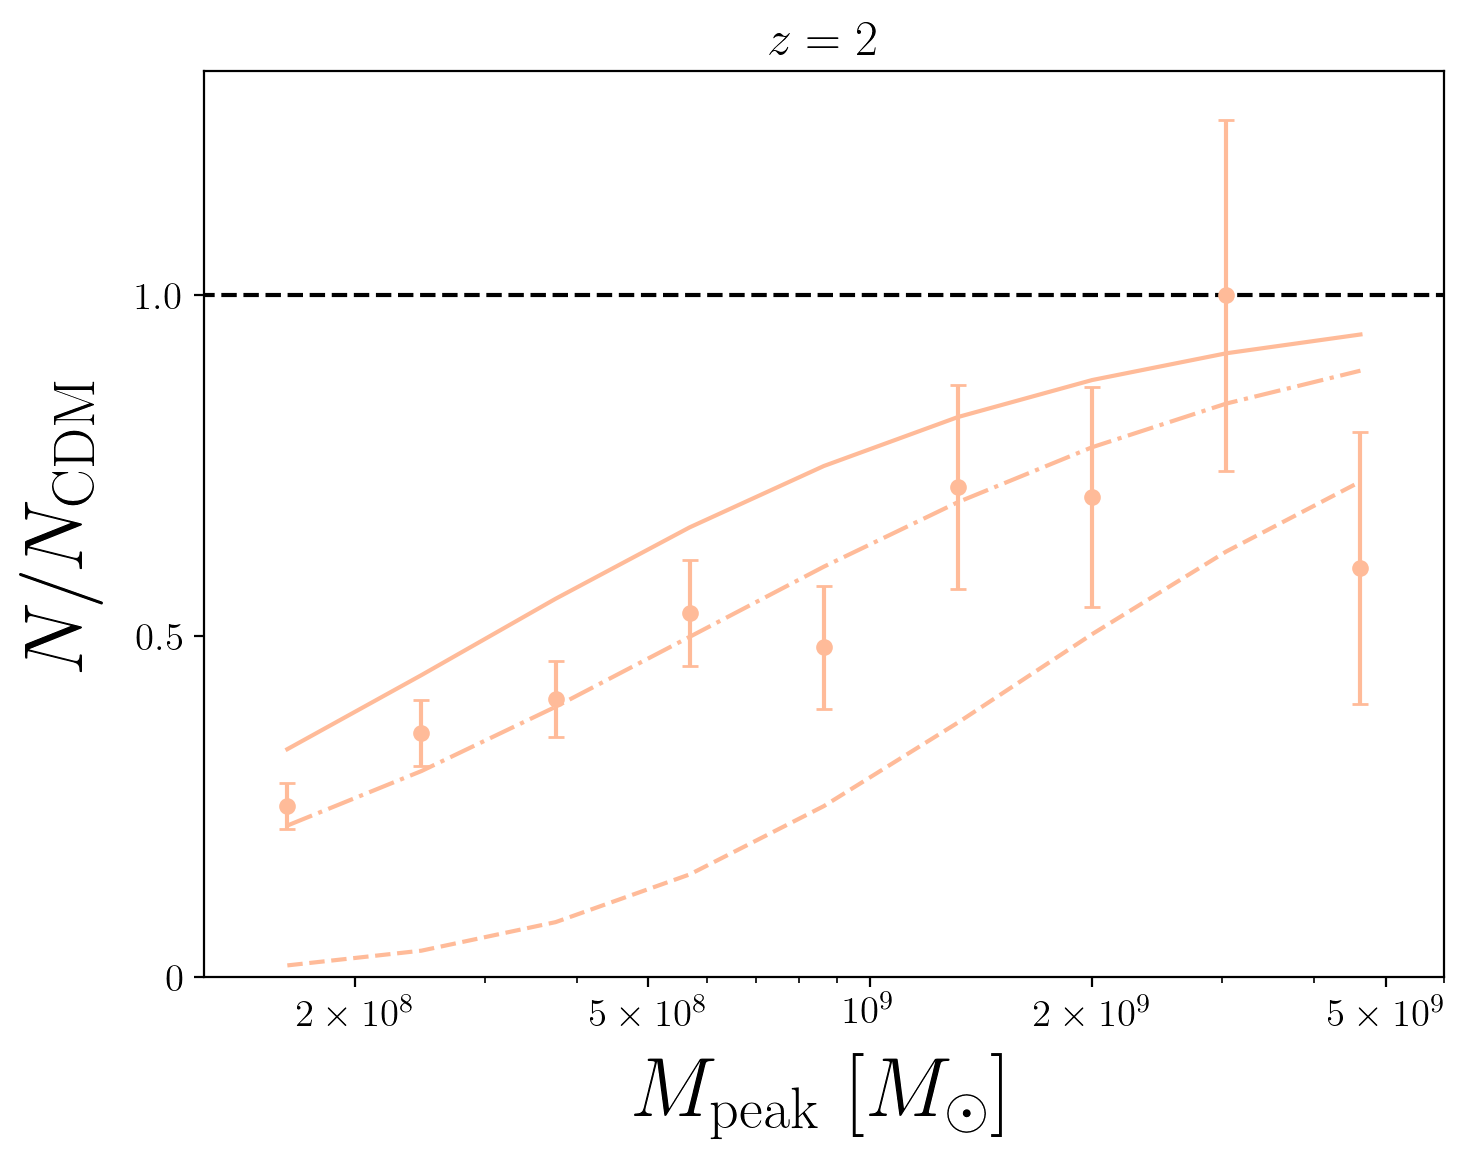

In [6]:
plt.figure(figsize=(8,6))
plt.xscale('log')

z_desired = 2
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])
###
# models = ['wdm_3', 'wdm_4', 'wdm_5','wdm_6','wdm_6.5', 'wdm_10']
models = ['wdm_3']
plt.plot(np.linspace(1e8,6e9,10),np.ones(10),ls='--',c='k')

for model in models:
    
    plt.scatter(0.5*(base_mpeak[1:]+base_mpeak[:-1]), wdm_shmf_mpeak_suppression[model][z],
                marker='o',color=sim_colors[model],s=10)

    plt.errorbar(0.5*(base_mpeak[1:]+base_mpeak[:-1]),wdm_shmf_mpeak_suppression[model][z],yerr=wdm_shmf_mpeak_suppression_err[model][z],
                 linestyle='none',marker='.',markersize=10,capsize=3,color=sim_colors[model])
    
    plt.plot(0.5*(base_mpeak[1:]+base_mpeak[:-1]),shmf_suppression_one_param((base_mpeak[1:]+base_mpeak[:-1]), float(model[4:])),
                c=sim_colors[model], label=f'one parameter')
    
    plt.plot(0.5*(base_mpeak[1:]+base_mpeak[:-1]),shmf_suppression_two_param((base_mpeak[1:]+base_mpeak[:-1]), float(model[4:])),
                c=sim_colors[model], label=f'two parameters', linestyle='--')
    
    plt.plot(0.5*(base_mpeak[1:]+base_mpeak[:-1]),shmf_suppression((base_mpeak[1:]+base_mpeak[:-1]), float(model[4:])),
                c=sim_colors[model], label=f'three parameters', linestyle='-.')

###

plt.xticks([2e8,5e8,1e9,2e9,5e9],[r'$2\times 10^8$',r'$5\times 10^8$',r'$10^9$',r'$2\times 10^9$',r'$5\times 10^9$'],fontsize=14)
plt.yticks([0,0.5,1.0],[r'$0$',r'$0.5$',r'$1.0$'], fontsize=14)

plt.xlim(1.25e8,6e9)
plt.ylim(0,1.33)

plt.xlabel(r'$M_{\rm{peak}}\ [M_{\mathrm{\odot}}]$',fontsize=30,labelpad=8)
plt.ylabel(r'$N/N_{\rm{CDM}}$', fontsize=30, labelpad=12)

# plt.legend(fontsize=12)
plt.title(f'$z = {z_desired}$', fontsize=18)

plt.show()

In [7]:
import scipy.optimize as so

In [8]:
mwdm = float(model[4:])
M = 0.5*(base_mpeak[1:]+base_mpeak[:-1])

def func1(M, beta): # same as shmf_suppression above
    return (1.+(Mhm(mwdm)/M))**-beta

def func2(M, beta, gamma):
    return (1.+((gamma*Mhm(mwdm))/M))**-beta

In [9]:
one_param = []

for z_desired in tqdm(np.linspace(0, 4.5, 50)):
    z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])
    
    try: 
        params, error = so.curve_fit(func1, M, wdm_shmf_mpeak_suppression[model][str(z)], maxfev=20000)
        params = np.append(params, z)
        one_param.append(params)
    except RuntimeError: pass
        

one_param = np.asarray(one_param, dtype=float)

100%|██████████| 50/50 [00:00<00:00, 295.67it/s]


In [10]:
two_param = []

for z_desired in tqdm(np.linspace(0, 4.5, 50)):
    z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])
    
    try: 
        params, error = so.curve_fit(func2, M, wdm_shmf_mpeak_suppression[model][str(z)], maxfev=20000)
        params = np.append(params, z)
        two_param.append(params)
    except RuntimeError: pass
        

two_param = np.asarray(two_param, dtype=float)

 64%|██████▍   | 32/50 [00:00<00:00, 126.90it/s]/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  
100%|██████████| 50/50 [00:00<00:00, 82.36it/s] 


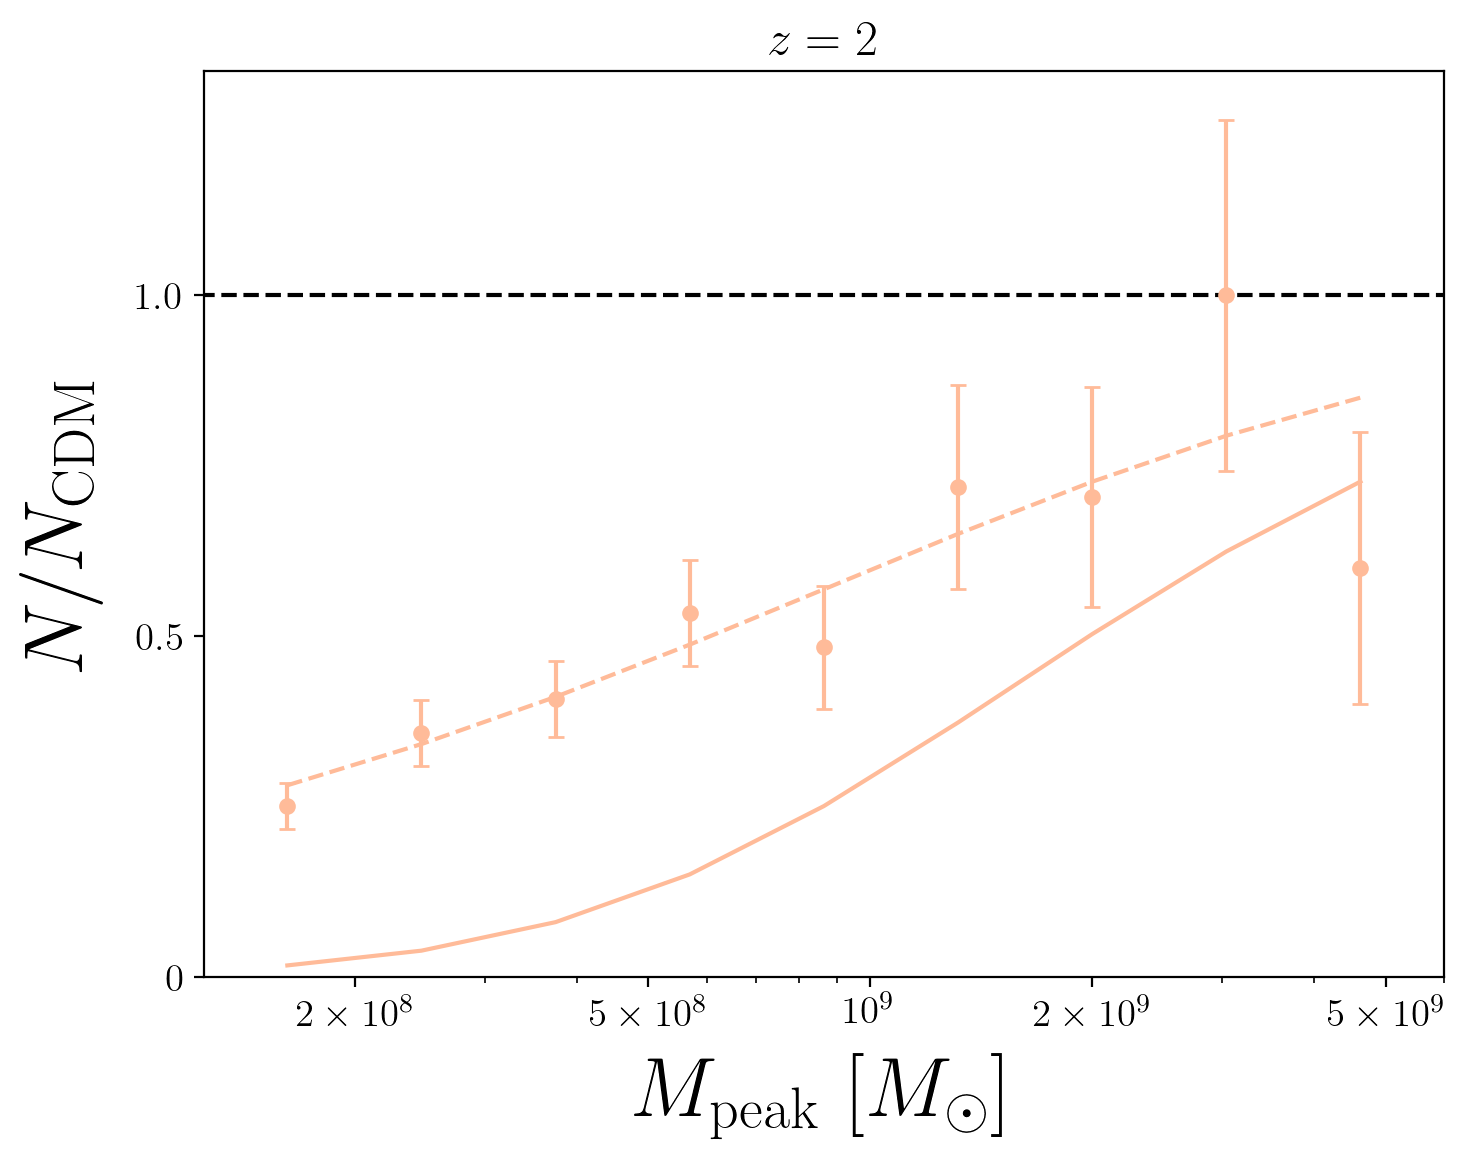

In [15]:


plt.figure(figsize=(8,6))
plt.xscale('log')

z_desired = 2
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])
###
# models = ['wdm_3', 'wdm_4', 'wdm_5','wdm_6','wdm_6.5', 'wdm_10']
models = ['wdm_3']
plt.plot(np.linspace(1e8,6e9,10),np.ones(10),ls='--',c='k')

params, error = so.curve_fit(func2, M, wdm_shmf_mpeak_suppression[model][str(z)], maxfev=20000)

for model in models:
    
    plt.scatter(0.5*(base_mpeak[1:]+base_mpeak[:-1]), wdm_shmf_mpeak_suppression[model][z],
                marker='o',color=sim_colors[model],s=10)

    plt.errorbar(0.5*(base_mpeak[1:]+base_mpeak[:-1]),wdm_shmf_mpeak_suppression[model][z],yerr=wdm_shmf_mpeak_suppression_err[model][z],
                 linestyle='none',marker='.',markersize=10,capsize=3,color=sim_colors[model])
    
    plt.plot(0.5*(base_mpeak[1:]+base_mpeak[:-1]),shmf_suppression_two_param((base_mpeak[1:]+base_mpeak[:-1]), float(model[4:])),
                c=sim_colors[model], label=f'Lovell+14')
    
    plt.plot(0.5*(base_mpeak[1:]+base_mpeak[:-1]), func2(M, *params),
                c=sim_colors[model], label=f'scipy fit', linestyle='--')

###

plt.xticks([2e8,5e8,1e9,2e9,5e9],[r'$2\times 10^8$',r'$5\times 10^8$',r'$10^9$',r'$2\times 10^9$',r'$5\times 10^9$'],fontsize=14)
plt.yticks([0,0.5,1.0],[r'$0$',r'$0.5$',r'$1.0$'], fontsize=14)

plt.xlim(1.25e8,6e9)
plt.ylim(0,1.33)

plt.xlabel(r'$M_{\rm{peak}}\ [M_{\mathrm{\odot}}]$',fontsize=30,labelpad=8)
plt.ylabel(r'$N/N_{\rm{CDM}}$', fontsize=30, labelpad=12)

# plt.legend(fontsize=12)
plt.title(f'$z = {z_desired}$', fontsize=18)

plt.show()

In [34]:
model = 'wdm_3'
mwdm = float(model[4:])

parameters_wdm3 = []

for z_desired in tqdm(np.linspace(0, 4.5, 50)):
    z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])
    
    try: 
        params, error = so.curve_fit(func2, M, wdm_shmf_mpeak_suppression[model][str(z)], maxfev=20000)
        params= np.append(params, z)
        parameters_wdm3.append(params)
    except RuntimeError: pass
        

parameters_wdm3 = np.array(parameters_wdm3, dtype=float)

 82%|████████▏ | 41/50 [00:00<00:00, 119.00it/s]/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  
100%|██████████| 50/50 [00:00<00:00, 80.62it/s] 


Text(0.5, 0, '$z$')

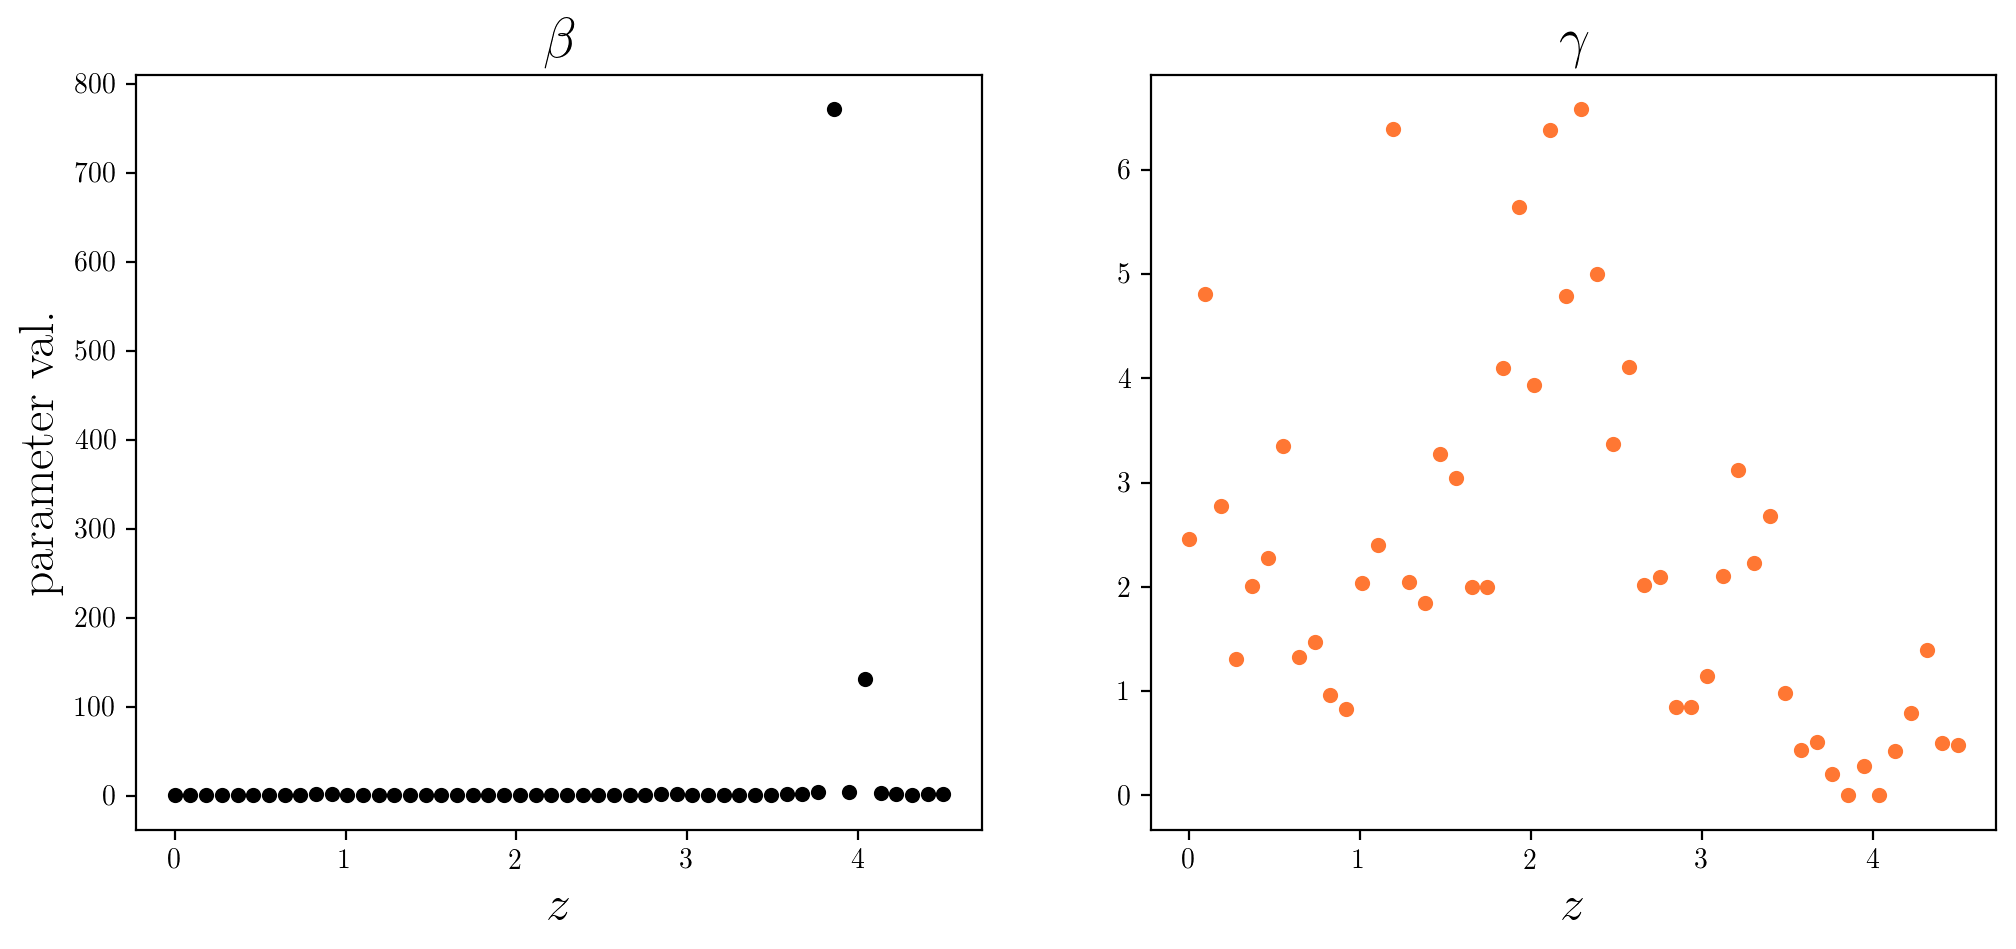

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))


ax[0].scatter(parameters_wdm3[:, 2], parameters_wdm3[:, 0], s=20, c=sim_colors['cdm'])
ax[0].set_title(r'$\beta$', fontsize=20)
ax[0].set_xlabel(r'$z$', fontsize=18)
ax[0].set_ylabel('parameter val.', fontsize=18)
# ax[0].set_ylim(-0.1, 1.5)
# ax[0].set_yscale('log')

ax[1].scatter(parameters_wdm3[:, 2], parameters_wdm3[:, 1], s=20, c=sim_colors['wdm_5'])
ax[1].set_title(r'$\gamma$', fontsize=20)
ax[1].set_xlabel(r'$z$', fontsize=18)
# ax[1].set_ylim(-0.1, 1.5)
# ax[1].set_yscale('log')


In [37]:
parameters_wdm3[:, 0]

array([8.12860068e-01, 5.54511932e-01, 7.20268129e-01, 1.11705598e+00,
       8.29715202e-01, 7.61246168e-01, 6.36759021e-01, 1.07693933e+00,
       1.00203610e+00, 1.31415366e+00, 1.42887144e+00, 8.18874150e-01,
       7.42587566e-01, 4.45500979e-01, 7.74923757e-01, 8.16916498e-01,
       5.90156045e-01, 5.89026564e-01, 7.51138245e-01, 7.46513847e-01,
       5.23427683e-01, 4.51358179e-01, 5.20947266e-01, 4.23293109e-01,
       4.84160604e-01, 4.17924045e-01, 4.71728832e-01, 5.78426872e-01,
       5.37932964e-01, 7.91938188e-01, 7.86806923e-01, 1.40073905e+00,
       1.43723451e+00, 1.18037205e+00, 8.13776563e-01, 6.38837807e-01,
       7.45141995e-01, 6.64083062e-01, 1.25306681e+00, 2.33920186e+00,
       2.21497379e+00, 4.61515907e+00, 7.71943723e+02, 3.82557005e+00,
       1.30525393e+02, 2.56033034e+00, 1.61791677e+00, 1.11643647e+00,
       2.18979557e+00, 2.36700574e+00])